Benchmarks for model order reduction in finance
============

### Benchmark Case 2.1: Classical Greedy Sampling

The main task of this research is to implement a parametric model order reduction
approach for financial risk analysis. Second benchmark case is to verify 
the implemented MOR algorithm. We use a finite difference method for 
simulating the convection-diffusion-reaction PDE. 
The projection-based MOR approach has been implemented, and 
the reduced-order basis is obtained using the proper orthogonal decomposition 
approach with the classical and adaptive greedy sampling methods.
This benchmark case runs the classical greedy sampling approach.

Inputs:
- Parameter space (a, b, sigma):
  - a - Deterministic drift
  -b - Mean reversion speed
- sigma - volatility
- Maximum number of greedy iterations: Imax
- Number of maximum training candidates: c

Outputs:
- Reduced Basis: Q_d
- Relative error between FOM and ROM: RelativeError
- Speed up factor: SpeedUpFactor


### Installation

Install the input/output and statistics Ocatave package for reading/writting .xlsx files and manage random samples

In [1]:
pkg install -forge io statistics
pkg load io statistics


The gnuplot graphics toolkit is not actively maintained and has a number
of limitations that are ulikely to be fixed.  Communication with gnuplot
uses a one-directional pipe and limited information is passed back to the
Octave interpreter so most changes made interactively in the plot window
will not be reflected in the graphics properties managed by Octave.  For
example, if the plot window is closed with a mouse click, Octave will not
be notified and will not update it's internal list of open figure windows.
We recommend using the qt toolkit instead.

error: get_forge_pkg: could not read URL, please verify internet connection
error: called from
    get_forge_pkg at line 72 column 7
    get_forge_download at line 32 column 14
    pkg at line 500 column 31
error: source: No such file or directory


### Computations

Model parameters

In [2]:
M = 800;              % grid points along spatial direction
T = 3660;             % Time to maturity in days (10 yrs)
lower = -0.08;        % Lower bound of r given by eq. 5.33 book by Andreas
upper = 0.08;
% Model Parameters
sigma = 0.006;
a1 = xlsread('../benchmarks/DD_1FHWModel_10000.xlsx');
a = a1(:,:);
b = 0.015;
% time step
dt =20/360;
% Maturity of a floater
MT = 10; % MT = 10 or 5
% Number of snapshots
NS = 10; % 10

Face value floor rate and cap rate with cap frequency 

In [3]:
FV =1;
FloorR = 0.005;
CapR = 0.025;
CopFre = 4; % CopFre = 4 or 2.
Maturity = 'Maturity10'; % Maturity = Maturity10, Maturity5.

Reference interest rate

In [4]:
SwapCurves = xlsread('../benchmarks/ReferenceRate_1906.xlsx'); %% Obtained by runing SwapCurveSimulation.nb file
FR1 = SwapCurves(:,[4:13]);
RRFR = repelem(FR1./CopFre,1,CopFre);

### Greedy Iterations

Simulate the full model for the first parameter group

In [5]:
% Here the first parameter group with a(1:1,:) and b, sigma is shown.
    [BOND,SnapShot1,Elapsed1] = FullModel(RRFR(1:1,:),a(1:1,:),b,sigma,M,...
        lower,upper,dt,MT,FV,FloorR,CapR,CopFre,NS,Maturity);
    
    % Compute SVD and obtain Q
    [U,~,V] = svd(SnapShot1{1},'econ');
    Q_Niter = U;
    
    % Select the random parameter groups.
    c = 20;
    RandSel = randsample(length(a),c);
    NpSel = a(RandSel,:);
    RefR = RRFR(RandSel,:);
    
    % Set max tolerance and number of max iterations
    Imax = 10;
    max_tol = 1*10^-5; %= 0.001;
    % Q_Niter = Q;
    
    tic;
    % Greedy iterations start
    for Niter = 2:Imax
        
        for j = 1:size(NpSel,1)    
            % Solve c reduced models and computes error estimators
            [BONDr,resd] = ReducedModel(RefR(j,:),NpSel(j,:),b,sigma,M,lower,...
                upper,dt,MT,FV,FloorR,CapR,CopFre,Q_Niter);
            Error(1,j) = resd; % Error estimators
        end
        
        % Average error esitmator
        avrg_error(1,(Niter-1)) = mean(Error);
        
        % Max locator
        [max_Error(1,(Niter-1)),max_idErr(1,(Niter-1))] = max(Error(:));
        
        % Next Q and break for next iteration if convergence reach
        if max_Error(1,(Niter-1)) < max_tol
            Q = Q_Niter;
            break
        end
        
        paraGr = cat(1,a(1,:),NpSel([max_idErr],:));
        RefRGr = cat(1,RRFR(1,:),RefR([max_idErr],:));
        
        [BOND,SnapShot_paraGr] = FullModel(RefRGr,paraGr,b,sigma,M,lower,...
            upper,dt,MT,FV,FloorR,CapR,CopFre,NS,Maturity);
        SnapShots = cat(2,SnapShot_paraGr{:});
        RankS(1,Niter-1) = rank(SnapShots); 
        
        % Randmized SVD of Snapshot matrix
        [U1,S1,V1] = RandSVD(SnapShots,RankS(1,Niter-1));
        
        Q_Niter = U1;
%     if Niter == NiterMax
%        Q = Q_Niter;
%     end
    end
    toc

Elapsed time is 1793.56 seconds.


Selection of the reduced dimension

In [6]:
Eg = diag(S1)./sum(diag(S1));
% 
for ii = 1:length(Eg)
    SumEg = sum(Eg(1:ii,1))*100;
    if SumEg > 99.99
        d = ii;
        break
    end
end

Q_d = Q_Niter(:,1:d);

Select random parameter group for testing

In [7]:
yy = randi([1 10000],1,1);

tStart = tic; 
[BOND1] = FullModel(RRFR(yy,:),a(yy,:),b,sigma,M,lower,upper,dt,MT,FV,...
    FloorR,CapR,CopFre,NS,Maturity);
tEnd = toc(tStart)*10;
% [BOND1] = FullModel(RRFR(yy,:),a(yy,:),b,sigma,M,lower,upper,dt,MT,FV,...
%     FloorR,CapR,CopFre,NS,Maturity);
% tEnd = toc(tStart)*10;
tFM = tEnd;

% % % % % % % % TotalTF = sum(Elapsed11);

tStartRM = tic; 
[BOND1r] = ReducedModel(RRFR(yy,:),a(yy,:),b,sigma,M,lower,upper,dt,MT,FV,...
    FloorR,CapR,CopFre,Q_d);
tEndRM = toc(tStartRM);
tRM = tEndRM*0.1;

Compute relative error and plot outputs

ans = -30.291
ans = -8.6858


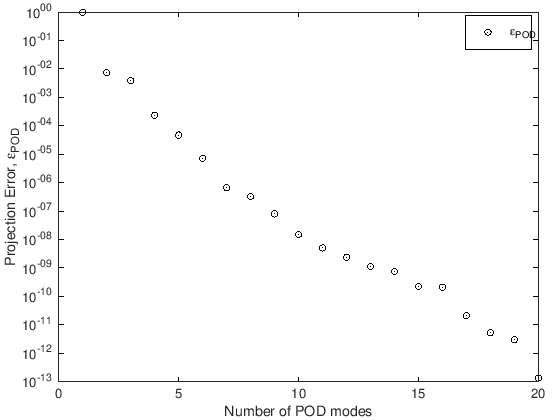

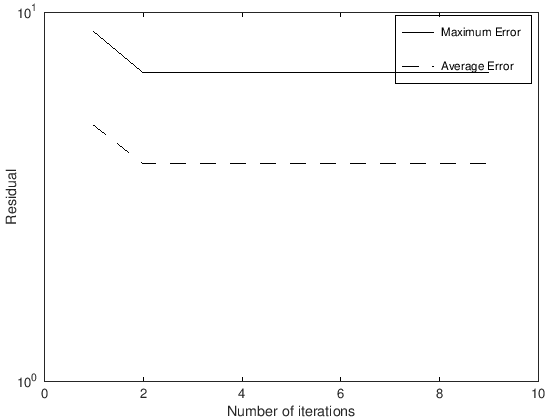

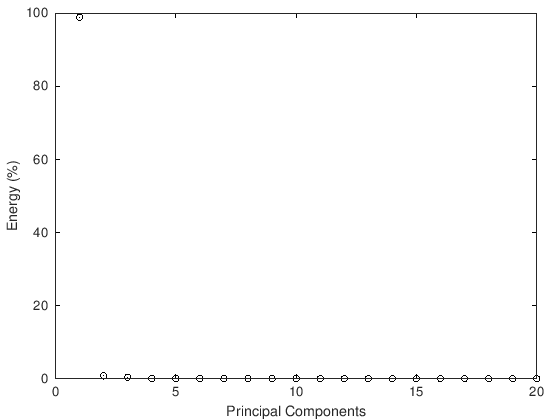

In [17]:
for kkk = 1:length(yy)
    RelativeError(1,kkk) = norm((BOND1{kkk} - BOND1r{kkk}),2)/norm(BOND1{kkk},2);
end

% Quantities to plot
avrgError_CG=avrg_error;MaxError_CG=max_Error;S=S1;

% Plot outputs
I = 1:Niter-1;
figure
semilogy(I,MaxError_CG,'k','LineWidth',1.5)
hold on
semilogy(I,avrgError_CG,'k--','LineWidth',1.5)
legend({'Maximum Error','Average Error'},'Location','NorthEast')
xlabel('Number of iterations')
ylabel('Residual')
hold off

figure
S2 = diag(S).^2;
sumS2 = sum(S2);
plot((S2/sumS2)*100,'ko','Linewidth',2); %Plot of singular values per mode
xlabel('Principal Components')
ylabel('Energy (%)')

figure
semilogy(S2/sum(S2),'ko','Linewidth',2); %logarithmic plot of singular values
legend({'\epsilon_{POD}'},'Location','NorthEast')
xlabel('Number of POD modes')
ylabel('Projection Error, \epsilon_{POD}')